In [6]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize_scalar

%matplotlib inline

In [7]:
def make_np_array(x):
    if type(x) != np.ndarray and type(x) != list and type(x) != tuple:
        return np.array([x])
    else:
        return np.array(x)

In [8]:
def check_convergence_region(algo, problem, x_0, sigma, iterations=50, size=1000, optimization_problem = True):
    points = np.random.normal(x_0, sigma, size=(size, x_0.shape[0]))
    successes = []
    for point in tqdm(points):
        x_history, values_history, times_history = algo(problem, point, iterations=iterations)
        
        if optimization_problem:
            result = np.min([np.linalg.norm(problem._g.forward(x), ord=2) for x in x_history])
        else:
            result = np.min(values_history)
        if result < 1e-3 * 1 / np.sqrt(x0.shape[0]):
            successes.append(1)
        else:
            successes.append(0)
    return points, successes

In [9]:
def draw_plots(values, times, names):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    
    for name_, values_ in zip(names, values):
        axs[0].plot(values_, label=name_)
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('log(Value)')
    axs[0].set_yscale('log')
    
    for name_, times_ in zip(names, times):
        axs[1].plot(times_, label=name_)
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Time, s')
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].legend(loc=1)
    axs[1].legend(loc=1)
    
    plt.show()

The considered equation has a form:

$\begin{cases} \big( x_k + \sum\limits_{i = 1}^{n - k - 1} x_i x_{i + k} \big) x_n - c_n = 0, 1 \leq k \leq n - 1 \\
\sum\limits_{i = 1}^{n - 1} x_i+ 1 = 0 \end{cases}$

So the **Jacobian** is:

If $i \neq n$, $j \neq n$:

$\frac{\partial g_i}{\partial x_i} = x_n + x_n x_{2i}I(i + i < n)$

$\frac{\partial g_i}{\partial x_j} = x_n x_{j}I(j + i < n) + x_n x_{j} I(j - i > 0)$

And if $i = n$:

$\frac{\partial g_n}{\partial x_n} = 0$, $\frac{\partial g_n}{\partial x_i} = 1$

And if $j = n$:

$\frac{\partial g_i}{\partial x_n} = x_i + \sum\limits_{l = 1}^{n - i - 1}x_lx_{l + i}$

And **Hessian** is:

If $i \neq n$, $j \neq n$:

$\frac{\partial^2 g_i}{\partial x_i^2} = 0$

$\frac{\partial^2 g_i}{\partial x_j^2} = 0$

And if $i = n$:

$\frac{\partial g_n}{\partial x_n} = 0$, $\frac{\partial g_n}{\partial x_i} = 1$

And if $j = n$:

$\frac{\partial g_i}{\partial x_n} = 0$

In [10]:
class EconomicModellingData():
    def __init__(self, k, constraint = None,
                 smallest_constraint=0,
                 largest_constraint=1):
        if constraint is None:
            self._c = smallest_constraint + (np.random.rand(k) * (largest_constraint - smallest_constraint))
        else:
            self._c = np.array(constraint)
            
    def forward(self, x):
        n = x.shape[0]
        assert n == self._c.shape[0] + 1
        first = np.array([(x[i] + (x[:n-i-2] * np.roll(x, shift=-i - 1)[:n-i-2]).sum()) * x[n - 1] - self._c[i] for i in range(n - 1)])
        last = np.sum(x[:n - 1]) + 1
        return np.hstack((first, last))
        
    def grad(self, x):
        n = x.shape[0]
        assert n == self._c.shape[0] + 1
        
        diag_part = x[n - 1] * np.diag(np.ones(n))
        diag_part[n - 1][n - 1] = 0
        main_part = np.zeros((n, n))
        
        for i in range(n - 1):
            main_part[n - 1][i] = 1
            main_part[i][n - 1] = x[i] + (x[:n-i-2] * np.roll(x, shift=-i - 1)[:n-i-2]).sum()
            for j in range(n - 1):
                if (i + j + 1 < n - 1):
                    main_part[i][j] += x[n - 1] * x[i + j + 1]
                if (j - i - 1 >= 0):
                    main_part[i][j] += x[n - 1] * x[j - i - 1]           
        
        return diag_part + main_part
    
    def hess(self, x):
        n = x.shape[0]
        return np.zeros((n, n))

In [11]:
def dump_forward(x, c):
    n = x.shape[0]
    
    output = np.zeros_like(x)
    for i in range(n - 1):
        output[i] = x[i]
        j = 0
        while(j + i + 1 < n - 1):
            output[i] += x[j] * x[j + i + 1]
            j += 1
        output[i] = output[i] * x[n - 1] - c[i]
        
    output[n - 1] = np.sum(x[:n - 1]) + 1
    return output

In [12]:
def dump_grad(x, c):
    n = x.shape[0]
    
    output = np.zeros((x.shape[0], x.shape[0]))
    for i in range(n - 1):
        for j in range(n - 1):
            if i == j:
                output[i][j] = x[n - 1]
                
            if j + i + 1 <= n - 2:
                output[i][j] += x[n - 1] * x[j + i + 1]
            
            if j - i - 1 >= 0:
                output[i][j] += x[n - 1] * x[j - i - 1]
    
    for j in range(n - 1):
        output[n - 1][j] = 1
    
    for i in range(n - 1):
        output[i][n - 1] = x[i]
        
        j = 0
        while(j + i + 1 < n - 1):
            output[i][n - 1] += x[j] * x[j + i + 1]
            j += 1
        
    return output

In [13]:
for shape in range(3, 200):
    x = np.random.rand(shape)
    e = EconomicModellingData(k=shape - 1)
    assert ((dump_grad(x, e._c) - e.grad(x)) ** 2).sum() < 1e-9

In [14]:
class EconomicModellingDataOptim():
    def __init__(self, g, p = 2):
        self._g = g
        self._p = p
    
    def forward(self, x):
        g = self._g.forward(x)
        return (g ** self._p).sum()
        
    def grad(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x)
        return self._p * grad_g.T @ (g ** (self._p - 1))
    
    def hess(self, x):
        x = np.array(x)
        
        g = self._g.forward(x)
        grad_g = self._g.grad(x) 
        return self._p * (self._p - 1) * grad_g.T @ np.diag(g ** (self._p - 2)) @ grad_g

# Experiment setup

We different system sizes: $\{10, 100, 1000 \}$.

As the norm of restrictions is not that large, I use try to find $x_0$ such that algorithm converges.

Then I generate a family of dots to figure out the convergence area.
Than I use PCA to illustrate the convergence area.

I also consider two cases - hard and easy ones. In the easy case the restrictions are zeroed, and the equation has an analytical solution, in the hard case restrictions are randomly generated.

In [15]:
SYSTEM_SIZES = [3, 10, 100]

In [16]:
gs, fs = [],[]

In [17]:
for i, size in enumerate(SYSTEM_SIZES):
    gs.append(EconomicModellingData(size - 1))
    fs.append(EconomicModellingDataOptim(gs[-1], p=2))

# Newton's Solving algorithm

In [21]:
class NewtonSolvingAlgorithm():
    def __init__(self):
        pass
    
    def solve(self, equation, x0, iterations=10, eps=1e-9, verbose=False):
        x = x0
        x_history = [x]
        values_history = [np.linalg.norm(equation.forward(x), ord=2)]
        times_history = [0]
        
        start = time()
        if verbose:
            iter_in = tqdm(range(iterations))
        else:
            iter_in = range(iterations)
        for i in iter_in:
            x = x - np.linalg.pinv(equation.grad(x)) @ equation.forward(x)
            
            values_history.append(np.linalg.norm(equation.forward(x), ord=2))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

## Finding x_0 such that algorithm converges...

In [22]:
x0s = []

In [23]:
for g in gs:
    not_converged = True
    print('Started...')
    while(not_converged):
        x0 = np.zeros(g._c.shape[0] + 1)
        point = np.random.normal(x0, np.ones(x0.shape[0]))
        x_history, values_history, times_history = NewtonSolvingAlgorithm().solve(g, point, iterations=50)
        if np.min(values_history) < 1e-3 * 1 / np.sqrt(x0.shape[0]):
            not_converged = False
            x0s.append(point)
        print(np.min(values_history))
    print('Finished...')
        

Started...
0.0
Finished...
Started...
3.623039646100254e-16
Finished...
Started...
26.022784082085547
1.028977203917542
1.1130362176956456e-14
Finished...


## Exploring algorithm behaviour in x_0...

In [24]:
def smooth_non_monotone_convergence(values_histories):
    new_values_history = [values_histories[0]]
    for i in range(1, len(values_histories)):
        new_values_history.append(min(new_values_history[-1], values_histories[i]))
    return new_values_history

In [25]:
x_history_ns_3, values_history_ns_3, times_history_ns_3 = NewtonSolvingAlgorithm().solve(gs[0], x0s[0], iterations=50, verbose=True)
x_history_ns_10, values_history_ns_10, times_history_ns_10 = NewtonSolvingAlgorithm().solve(gs[1], x0s[1], iterations=50, verbose=True)
x_history_ns_100, values_history_ns_100, times_history_ns_100 = NewtonSolvingAlgorithm().solve(gs[2], x0s[2], iterations=50, verbose=True)

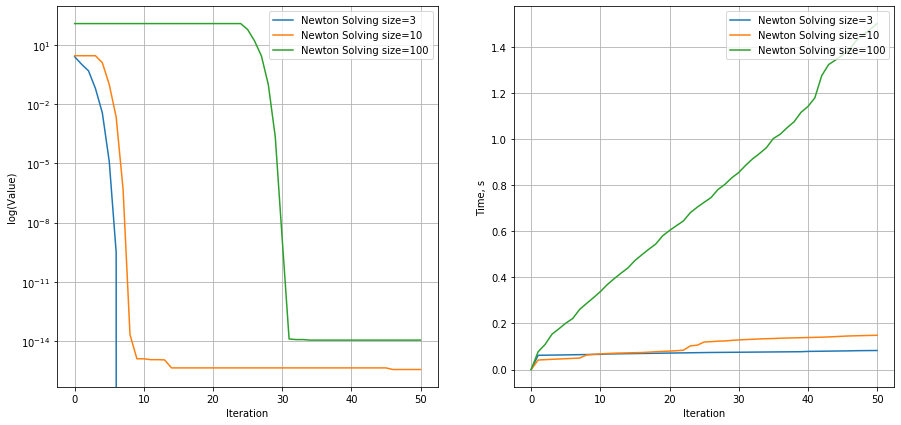

In [26]:
draw_plots([smooth_non_monotone_convergence(values_history_ns_3),
            smooth_non_monotone_convergence(values_history_ns_10),
            smooth_non_monotone_convergence(values_history_ns_100)],
          [times_history_ns_3, times_history_ns_10, times_history_ns_100],
          ['Newton Solving size=3', 'Newton Solving size=10', 'Newton Solving size=100'])

In [27]:
# good points, which are close to the minimum
good_x0s = [x_history_ns_3[-1], x_history_ns_10[-1], x_history_ns_100[-1]]

In [30]:
points_3, successes_3 = check_convergence_region(NewtonSolvingAlgorithm().solve, gs[0], x0s[0],
                                                   1000, size=1000, optimization_problem=False)


In [20]:
points_10, successes_10 = check_convergence_region(NewtonSolvingAlgorithm().solve, gs[1], x0s[1],
                                                   100, size=1000, optimization_problem=False)


In [21]:
points_100, successes_100 = check_convergence_region(NewtonSolvingAlgorithm().solve, gs[2], x0s[2],
                                                   1, size=100, optimization_problem=False)

In [31]:
print(f'size=3,   sigma=1000, trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000}, negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=100, sigma=100,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=300, sigma=1,    trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3,   sigma=1000, trials=1000, positive: 1.0, negative: 0.0 
size=100, sigma=100,  trials=1000, positive: 0.551, negative: 0.449 
size=300, sigma=1,    trials=100,  positive: 0.42, negative: 0.58 


# Newton's Optimizing algorithm

Levenberg-Marquart can be used here to receive more stable results.

In [196]:
class NewtonOptimizationAlgorithm():
    def __init__(self):
        pass
    
    def optimize(self, function, x0, iterations=10, eps=1e-9, verbose=False):
        x = x0
        
        x_history = [x]
        values_history = [function.forward(x)]
        times_history = [0]
        
        start = time()
        if verbose:
            iter_in = tqdm(range(iterations))
        else:
            iter_in = range(iterations)
        for i in iter_in:
            x = x - np.linalg.pinv(function.hess(x) + eps * np.eye(x.shape[0])) @ function.grad(x)
            
            if np.isnan(x).any():
                break
            values_history.append(function.forward(x))
            x_history.append(x)
            times_history.append(time() - start)
        return x_history, values_history, times_history

## Find x_0 where algorithm converges...

In [197]:
x0s = []

In [198]:
for i in range(3):
    not_converged = True
    print('Started...')
    f = fs[i]
    g = gs[i]
    
    while(not_converged):
        x0 = np.zeros(g._c.shape[0] + 1)
        point = np.random.normal(x0, np.ones(x0.shape[0]))
        point = good_x0s[i] + point
        x_history, values_history, times_history = NewtonOptimizationAlgorithm().optimize(f, point, iterations=100, eps=1e-7)
        if np.sqrt(np.min(values_history)) < 1e-3 * 1 / np.sqrt(x0.shape[0]):
            not_converged = False
            x0s.append(point)
        print(np.min(values_history))
    print('Finished...')

Started...
0.0
Finished...
Started...
1.3126416277214254e-31
Finished...
Started...
30.663526135456124
3.610109040498629
9.06212631557387e-29
Finished...


## Convergence plots

In [199]:
x_history_no_3, values_history_no_3, times_history_no_3 = NewtonOptimizationAlgorithm().optimize(fs[0], x0s[0], iterations=50, verbose=True, eps=1e-7)
x_history_no_10, values_history_no_10, times_history_no_10 = NewtonOptimizationAlgorithm().optimize(fs[1], x0s[1], iterations=100, verbose=True, eps=1e-7)
x_history_no_100, values_history_no_100, times_history_no_100 = NewtonOptimizationAlgorithm().optimize(fs[2], x0s[2], iterations=100, verbose=True, eps=1e-7)


In [200]:
g_values_history_no_3 =  [np.linalg.norm(gs[0].forward(x), ord=2) for x in x_history_no_3]
g_values_history_no_10 = [np.linalg.norm(gs[1].forward(x), ord=2) for x in x_history_no_10]
g_values_history_no_100 = [np.linalg.norm(gs[2].forward(x), ord=2) for x in x_history_no_100]

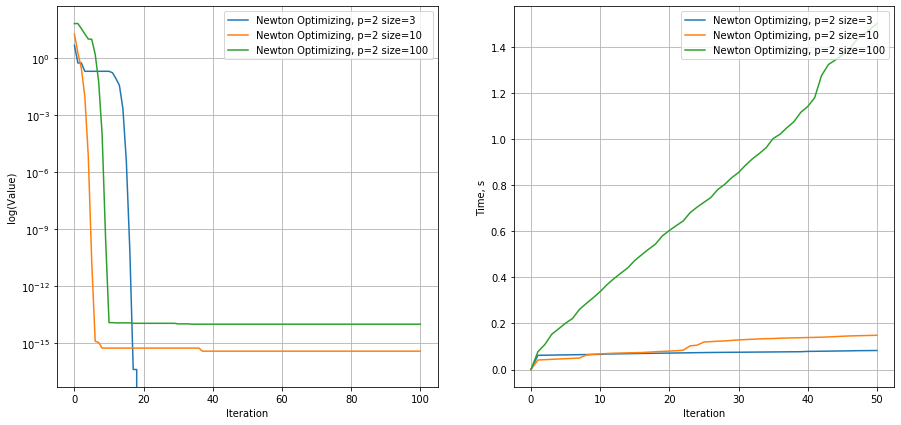

In [201]:
draw_plots([smooth_non_monotone_convergence(g_values_history_no_3),
            smooth_non_monotone_convergence(g_values_history_no_10),
            smooth_non_monotone_convergence(g_values_history_no_100)],
          [times_history_ns_3, times_history_ns_10, times_history_ns_100],
          ['Newton Optimizing, p=2 size=3', 'Newton Optimizing, p=2 size=10', 'Newton Optimizing, p=2 size=100'])

## Convergence area analysis

In [169]:
points_3, successes_3 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, fs[0], x0s[0],
                                                 1000, size=1000)

In [170]:
points_10, successes_10 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, fs[1], x0s[1],
                                                   100, size=1000)


In [171]:
points_100, successes_100 = check_convergence_region(NewtonOptimizationAlgorithm().optimize, fs[2], x0s[2],
                                                   1, size=100)

In [172]:
print(f'size=3,   sigma=1000, trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000}, negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=100, sigma=100,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=300, sigma=1,    trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3,   sigma=1000, trials=1000, positive: 0.193, negative: 0.807 
size=100, sigma=100,  trials=1000, positive: 0.003, negative: 0.997 
size=300, sigma=1,    trials=100,  positive: 0.5, negative: 0.5 


# Conjugated Gradients

In [202]:
class ConjugateGradient():
    def __init__(self):
        pass
    
    def optimize(self, regression, x0, iterations=10, method='fletcher-reeves', default_step=0.01,
                line_search_iter=50, line_search_tolerance=10, verbose=False):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
        
        # conjugate direction
        d = -regression.grad(x)
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        
        if verbose:
            iter_in = tqdm(range(iterations))
        else:
            iter_in = range(iterations)
        for i in iter_in:
            # line search alpha
            #alpha = line_search(regression.forward, regression.grad, x, d, maxiter=100)[0]
            
            alpha = minimize_scalar(lambda l: regression.forward(x + l * d),
                                       bounds=(0, default_step), method='Brent',
                                       options={'maxiter':line_search_iter,
                                                'xtol': default_step / line_search_tolerance})
            alpha = alpha['x']
            if alpha == 0:
                if verbose:
                    print(f'Line search did not converge on iteration {i}, using default step')
                alpha = default_step / (i + 1)
                #return x_history, values_history, times_history
            
            # update x_k + 1
            x = x + alpha * d
            x_history.append(x)
            values_history.append(regression.forward(x))
            
            # compute g_k + 1
            g = regression.grad(x)
            grads_history.append(g)
            
            # update d_k + 1
            if method == 'fletcher-reeves':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = (g.T @ g) / (grads_history[-2].T @ grads_history[-2])
            elif method == 'polak-ribiere':
                if (grads_history[-2].T @ grads_history[-2]) == 0:
                    beta = 0
                else:
                    beta = ((g - grads_history[-2]).T @ g) / (grads_history[-2].T @ grads_history[-2])
            else:
                raise Exception(f'Unknown method: {method}')
            d = -g + beta * d
            
            # update times history
            times_history.append(time() - start)
        if verbose:
            print(f'Conjugate gradient converged on iteration {i}')
        return x_history, values_history, times_history

## Conjugated Gradients: Fletcher-Reeves

In [195]:
MAX_POINTS = 20

In [196]:
x0s = []
for i in range(3):
    not_converged = True
    print('Started...')
    f = fs[i]
    g = gs[i]
    
    considered_dots = 0
    x0 = np.zeros(g._c.shape[0] + 1)
    x0s.append(x0)
    while(not_converged and considered_dots < MAX_POINTS):
        if SYSTEM_SIZES[i] <= 10:
            point = np.random.normal(x0, np.ones(x0.shape[0]))
        else:
            point = np.random.normal(x0, np.ones(x0.shape[0]) * 5e-3)
        point = good_x0s[i] + point
        x_history, values_history, times_history = ConjugateGradient().optimize(f, point, iterations=300,  method='fletcher-reeves')
        if np.sqrt(np.min(values_history)) < 1e-3 * 1 / np.sqrt(x0.shape[0]):
            not_converged = False
            x0s[-1] = point
        
        if np.min(values_history) < f.forward(x0s[-1]):
            x0s[-1] = point
            
        considered_dots += 1
        print(np.min(values_history))
    print('Finished...')

Started...
0.0
Finished...
Started...


/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered i

nan


/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app


nan
1.2847728759180632e-08
Finished...
Started...
1.6976915924765498e-08
3.626339452443735e-08
4.3687647995974554e-09
Finished...


### Convergence plots

In [197]:
x_history_no_3, values_history_no_3, times_history_no_3 = ConjugateGradient().optimize(fs[0], x0s[0], iterations=300, verbose=True)
x_history_no_10, values_history_no_10, times_history_no_10 = ConjugateGradient().optimize(fs[1], x0s[1], iterations=300, verbose=True)
x_history_no_100, values_history_no_100, times_history_no_100 = ConjugateGradient().optimize(fs[2], x0s[2], iterations=300, verbose=True)


Conjugate gradient converged on iteration 299



Conjugate gradient converged on iteration 299



Conjugate gradient converged on iteration 299


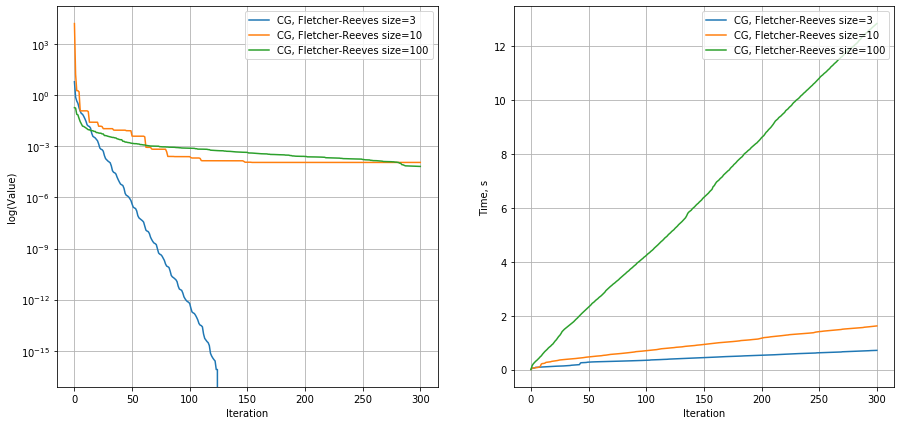

In [198]:
# to get second norm of g we can just take square root of f 
draw_plots([np.sqrt(values_history_no_3), np.sqrt(values_history_no_10), np.sqrt(values_history_no_100)],
          [times_history_no_3, times_history_no_10, times_history_no_100],
          ['CG, Fletcher-Reeves size=3', 'CG, Fletcher-Reeves size=10', 'CG, Fletcher-Reeves size=100'])

## Convergence area analysis

In [200]:
points_3, successes_3 = check_convergence_region(ConjugateGradient().optimize, fs[0], x0s[0],
                                                 1000, size=1000)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in add
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value e

In [201]:
points_10, successes_10 = check_convergence_region(ConjugateGradient().optimize, fs[1], x0s[1],
                                                   100, size=1000)


/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in doub

In [202]:
points_100, successes_100 = check_convergence_region(ConjugateGradient().optimize, fs[2], x0s[2],
                                                   1, size=100)

In [203]:
print(f'size=3, sigma=1000,  trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000},  negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=10, sigma=100,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=100, sigma=1,   trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3, sigma=1000,  trials=1000, positive: 0.007,  negative: 0.993 
size=10, sigma=100,  trials=1000, positive: 0.0, negative: 1.0 
size=100, sigma=1,   trials=100,  positive: 0.0, negative: 1.0 


In [204]:
points_3, successes_3 = check_convergence_region(ConjugateGradient().optimize, fs[0], x0s[0],
                                                 100, size=1000)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in add
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: 

In [208]:
points_10, successes_10 = check_convergence_region(ConjugateGradient().optimize, fs[1], x0s[1],
                                                   1e-1, size=1000)

In [209]:
points_100, successes_100 = check_convergence_region(ConjugateGradient().optimize, fs[2], x0s[2],
                                                   1e-3, size=100)

In [211]:
print(f'size=3, sigma=1000,  trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000},  negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=10, sigma=1e-1,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=100, sigma=1e-3,   trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3, sigma=1000,  trials=1000, positive: 0.042,  negative: 0.958 
size=10, sigma=1e-1,  trials=1000, positive: 0.0, negative: 1.0 
size=100, sigma=1e-3,   trials=100,  positive: 0.0, negative: 1.0 


## Conjugated Gradients: Polyak-Ribiere

In [203]:
MAX_POINTS = 20

In [204]:
x0s = []
for i in range(3):
    not_converged = True
    print('Started...')
    f = fs[i]
    g = gs[i]
    
    considered_dots = 0
    x0 = np.zeros(g._c.shape[0] + 1)
    x0s.append(x0)
    while(not_converged and considered_dots < MAX_POINTS):
        if SYSTEM_SIZES[i] == 10:
            point = np.random.normal(x0, np.ones(x0.shape[0]) * 1e-3)
        elif SYSTEM_SIZES[i] == 3:
            point = np.random.normal(x0, np.ones(x0.shape[0]))
        elif SYSTEM_SIZES[i] == 100:
            point = np.random.normal(x0, np.ones(x0.shape[0]) * 1e-3)
        point = good_x0s[i] + point
        x_history, values_history, times_history = ConjugateGradient().optimize(f, point, iterations=300,  method='polak-ribiere')
        if np.sqrt(np.min(values_history)) < 1e-3 * 1 / np.sqrt(x0.shape[0]):
            not_converged = False
            x0s[-1] = point
            
        if np.min(values_history) < f.forward(x0s[-1]):
            x0s[-1] = point
            
        considered_dots += 1
        print(np.min(values_history))
    print('Finished...')

Started...
0.0
Finished...
Started...
1.4398033891410784e-17
Finished...
Started...
1.9708694013958438e-09
Finished...


### Convergence plots

In [205]:
x_history_no_3, values_history_no_3, times_history_no_3 = ConjugateGradient().optimize(fs[0], x0s[0], iterations=300, verbose=True, method='polak-ribiere')
x_history_no_10, values_history_no_10, times_history_no_10 = ConjugateGradient().optimize(fs[1], x0s[1], iterations=300, verbose=True, method='polak-ribiere')
x_history_no_100, values_history_no_100, times_history_no_100 = ConjugateGradient().optimize(fs[2], x0s[2], iterations=300, verbose=True, method='polak-ribiere')



Conjugate gradient converged on iteration 299



Conjugate gradient converged on iteration 299



Conjugate gradient converged on iteration 299


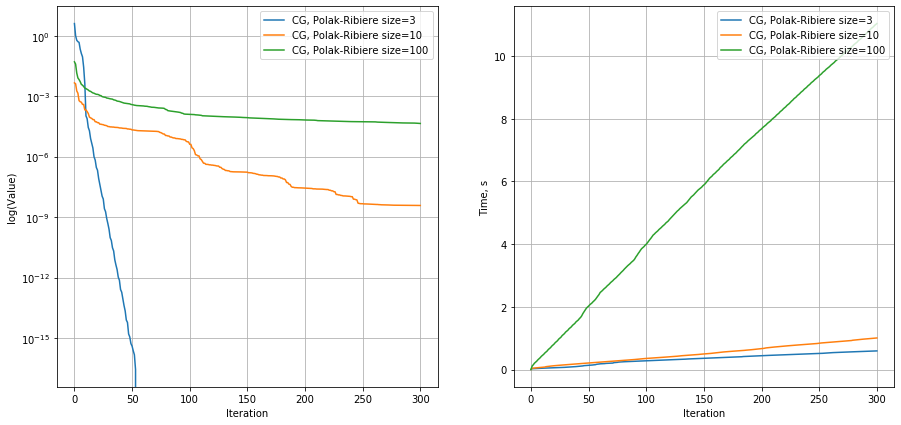

In [206]:
draw_plots([np.sqrt(values_history_no_3), np.sqrt(values_history_no_10), np.sqrt(values_history_no_100)],
          [times_history_no_3, times_history_no_10, times_history_no_100],
          ['CG, Polak-Ribiere size=3', 'CG, Polak-Ribiere size=10', 'CG, Polak-Ribiere size=100'])

## Convergence area analysis

In [228]:
from functools import partial

In [229]:
points_3, successes_3 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'),
                                                 fs[0], x0s[0],
                                                 1000, size=1000)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in add
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value e

In [230]:
points_10, successes_10 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), fs[1], x0s[1],
                                                   100, size=1000)


/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_lau

In [231]:
points_100, successes_100 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), fs[2], x0s[2],
                                                   1, size=100)

In [232]:
print(f'size=3, sigma=1000,  trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000},  negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=10, sigma=100,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=100, sigma=1,   trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3, sigma=1000,  trials=1000, positive: 0.016,  negative: 0.984 
size=10, sigma=100,  trials=1000, positive: 0.0, negative: 1.0 
size=100, sigma=1,   trials=100,  positive: 0.0, negative: 1.0 


In [233]:
points_3, successes_3 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), fs[0], x0s[0],
                                                 100, size=1000)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in square
  
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in add
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid va

In [244]:
points_10, successes_10 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), fs[1], x0s[1],
                                                   5e-3, size=1000)

/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in matmul
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/Users/dragonstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered i

In [245]:
points_100, successes_100 = check_convergence_region(partial(ConjugateGradient().optimize, method='polak-ribiere'), fs[2], x0s[2],
                                                   1e-6, size=100)

In [246]:
print(f'size=3, sigma=1000,  trials=1000, positive: {(np.array(successes_3) == 1).sum() / 1000},  negative: {(np.array(successes_3) == 0).sum() / 1000} ')
print(f'size=10, sigma=5e-3,  trials=1000, positive: {(np.array(successes_10) == 1).sum() / 1000}, negative: {(np.array(successes_10) == 0).sum() / 1000} ')
print(f'size=100, sigma=1e-6,   trials=100,  positive: {(np.array(successes_100) == 1).sum() / 100}, negative: {(np.array(successes_100) == 0).sum() / 100} ')

size=3, sigma=1000,  trials=1000, positive: 0.345,  negative: 0.655 
size=10, sigma=5e-3,  trials=1000, positive: 0.163, negative: 0.837 
size=100, sigma=1e-6,   trials=100,  positive: 0.0, negative: 1.0 


# Accelerated Residuals

In [86]:
class AcceleratedResiduals():
    def __init__(self):
        pass
    
    def optimize(self, equation, x0=None, alpha=0.1, iterations=50, verbose=False, n=1, tol=1e-3 / np.sqrt(100), line_search_iter=100):
        # random guess
        if x0 is None:
            u = np.random.rand(function.A.shape[1])
        else: 
            u = x0

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        u_history = [u]
        values_history = [np.linalg.norm(equation.forward(u))]
        times_history = [0]
        
        if verbose:
            pbar = tqdm(total=iterations)
        
        k = 0
        total_iters = 0
        alpha_k = alpha
        while (k <= iterations) and (total_iters <= iterations):
#             def objective_forward(alpha):
#                 return np.linalg.norm(equation.forward(u - alpha * equation.forward(u)))
            
#             alpha_k = minimize_scalar(objective_forward, bounds=(0, 1), method='bounded', options={'maxiter':line_search_iter})
#             alpha_k = alpha_k['x']
            if k == 0:
                v_k = u - alpha_k * equation.forward(u)
            else:
                beta_k = np.linalg.norm(equation.forward(u), ord=2) / np.linalg.norm(equation.forward(u_history[-2]), ord=2)
                v_k = u + beta_k * (u - u_history[-2]) - alpha_k * (1 + beta_k) * equation.forward(u)
            
            u = v_k - alpha_k * equation.forward(v_k)
            
            u_history.append(u)
            values_history.append(np.linalg.norm(equation.forward(u), ord=2))         
            times_history.append(time() - start)
            if values_history[-1] <= tol:
                if verbose:
                    print(f'Accelerated residuals converged on iteration {total_iters}')
                for i in range(total_iters, iterations):
                    u_history.append(u_history[-1])
                    values_history.append(values_history[-1])
                    times_history.append(times_history[-1])
                break
            if k > n and values_history[-1] > values_history[-1 - n]:
                u = x_history[-2]
                k = 0
            if verbose:
                pbar.update(1)
            total_iters += 1
            
            if total_iters > iterations:
                break
        return u_history, values_history, times_history

## Finding x_0...

In [179]:
x0s = []
x0s.append(good_x0s[0] + 1)
x0s.append(good_x0s[1] + 1)
x0s.append(good_x0s[2] + 1)

In [181]:
x_history_3, values_history_3, times_history_3 = AcceleratedResiduals().optimize(gs[0], x0s[0], iterations=3000, verbose=True, alpha=1e-10)
x_history_10, values_history_10, times_history_10 = AcceleratedResiduals().optimize(gs[1], x0s[1], iterations=3000, verbose=True, alpha=1e-10)
x_history_100, values_history_100, times_history_100 = AcceleratedResiduals().optimize(gs[2], x0s[2], iterations=3000, verbose=True, alpha=1e-10)

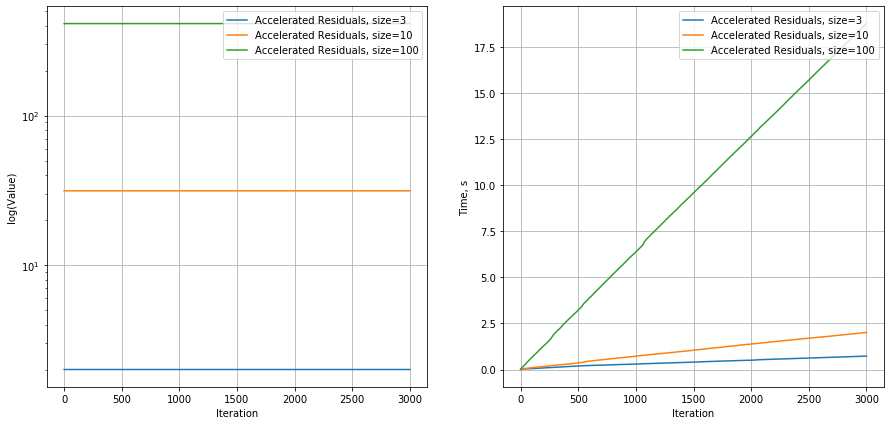

In [148]:
draw_plots([values_history_3, values_history_10, values_history_100],
          [times_history_3, times_history_10, times_history_100],
          ['Accelerated Residuals, size=3', 'Accelerated Residuals, size=10', 'Accelerated Residuals, size=100'])

In [194]:
x_history_3, values_history_3, times_history_3 = AcceleratedResiduals().optimize(gs[0], x0s[0], n = 1000, iterations=300000, verbose=True, alpha=1e-7)


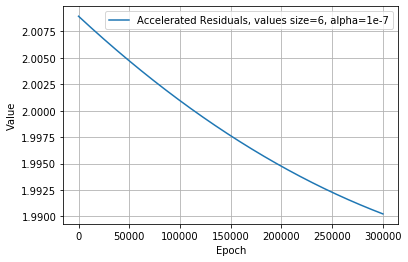

In [195]:
plt.plot(values_history_3, label='Accelerated Residuals, values size=6, alpha=1e-7')
plt.grid()
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()